In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Narma10
Non linear autoregressive moving average task: we have two time series, $X=(x_t)$ and $Y=(y_t)$. The input sequence $X$ is chosen randomly in $[0, 0.5]$.

The target ts $y$ is defined by
$$ y(t)=0.3 y(t-1) + 0.05 y(t-1) \left( \sum_{i=1}^{10} y(t-i)\right) +1.5 x(t-10)x(t-1) + 0.1$$
The goal, given the input $x(t)$, is to predict $y(t)$.

In [88]:
df = pd.read_csv('../datasets/NARMA10.csv', header=None)
x = torch.Tensor(df.iloc[0,:])
y = torch.Tensor(df.iloc[1,:])

In [89]:
x =x.unsqueeze(0)
y =y.unsqueeze(0)
x.shape, y.shape

(torch.Size([1, 10000]), torch.Size([1, 10000]))

In [90]:
x_train = x[:, :4000]
x_val = x[:, 4000:5000]
x_dev = x[:, :5000] # train + val
x_test = x[:, 5000:]
y_train = y[:, :4000]
y_val = y[:, 4000:5000]
y_dev = y[:, :5000] # train + val
y_test = y[:, 5000:]

x_dev.shape, y_dev.shape

(torch.Size([1, 5000]), torch.Size([1, 5000]))

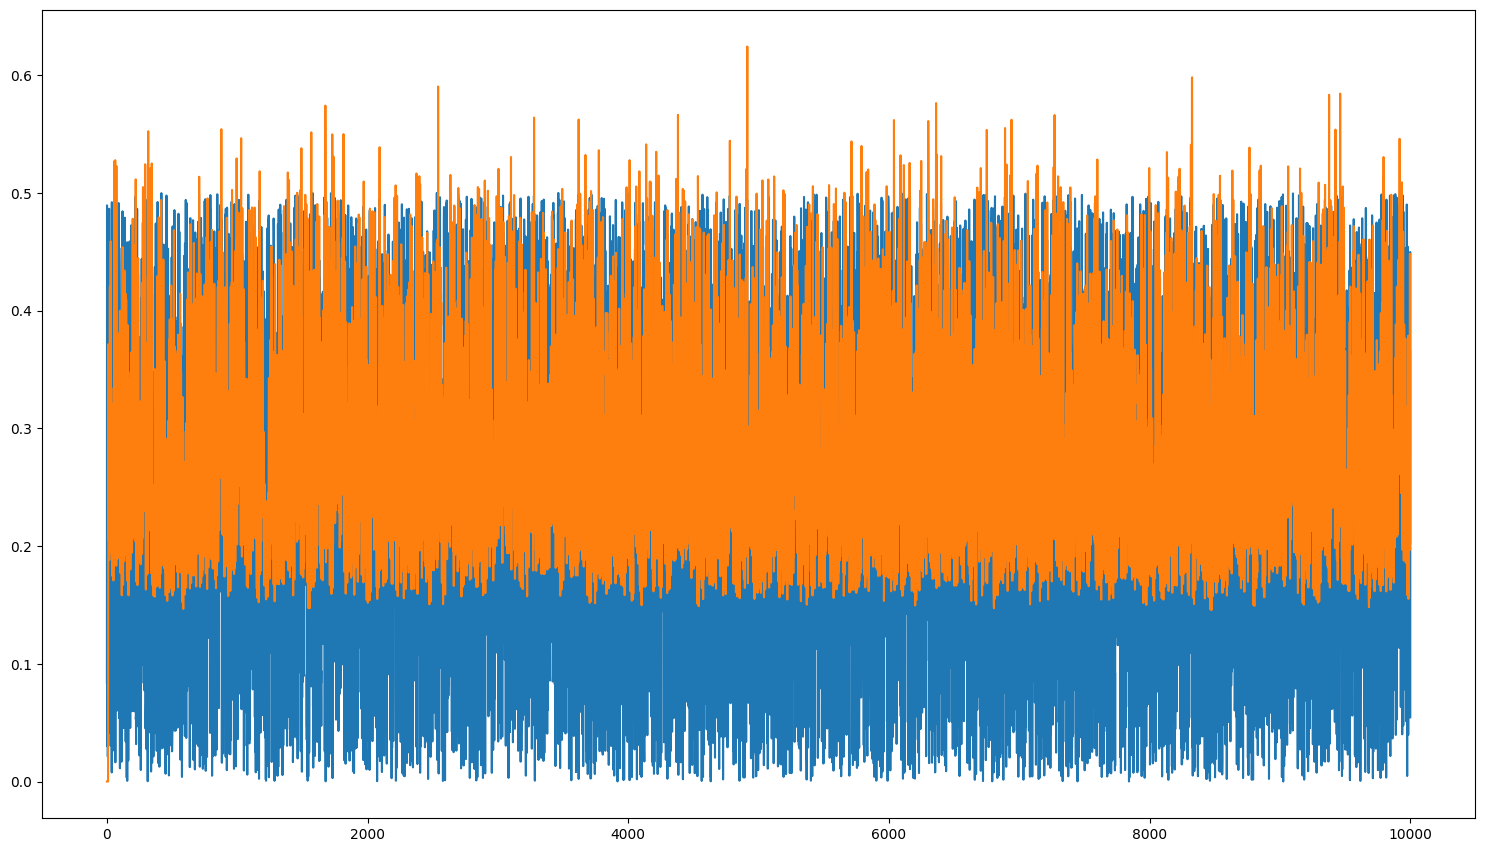

In [6]:
fig, ax = plt.subplots()

plt.plot( torch.arange(10000), x[0,:], y[0,:])
# adjust figure size
fig.set_size_inches(18.5, 10.5)
plt.show()

## TDNN
The first model is a Time Delay NN (TDNN). This type of network consist in a 1D convolution without stride, or equivalently a standard multi layer perceptron applied to a fixed size window of the input:
if $X = (x_t)_{t=1}^{T}$ is the input time series, a TDNN applies the same MLP to  $(x_{t-\tau},...,x_{t})$, where $\tau$ is the window size.

I opted for a very simple implementation, consisting in one hidden ReLU MLP layer. The time delay is obtained by simply sliding the MLP along the time series

In [11]:
class TDNN(nn.Module):
    def __init__(self, window_size:int, hidden_size: int, output_size:int):
        super(TDNN, self).__init__()
        self.window_size =window_size
        self.td = nn.Linear(window_size, hidden_size)   
        self.relu=nn.ReLU()
        self.linear = nn.Linear(hidden_size, output_size)
    
    def pad_input(self, x:torch.Tensor):
        pad_size = self.window_size - x.shape[1]
        return torch.cat(torch.zeros(1, pad_size), x)

    def forward(self, x:torch.Tensor):
        """
        just a 2 layer feedforward network applied on time windows of the input
        """
        if x.shape[1] < self.window_size:
            x= self.pad_input(x)
        h = self.relu(self.td(x))
        o = self.linear(h)
        return o.squeeze(0)
        

In [12]:
y_val.mean()

tensor(0.2773)

In [13]:
x=torch.tensor([[1]])
x.squeeze(0).shape, x.squeeze(0)

(torch.Size([1]), tensor([1]))

In the first experiment, we feed the network the inputs $x(t- \tau),..., x(t)$, where $\tau =10$ is the window size. The window size is clearly ideal from the specifications of the problem.

### Training Loop

In [36]:
import torch
from tqdm import tqdm

def train_tdnn(tdnn, optimizer, loss_fn, mae_fn, x_train, y_train, x_val, y_val, epochs=100, n_steps_update=32, patience=5, eps=1e-5):
    train_losses_tdnn = []
    train_maes_tdnn = []
    val_losses_tdnn = []
    val_maes_tdnn = []

    
    best_val_loss = np.inf
    patience_counter = 0
    
    for epoch in range(epochs):
        running_loss = 0
        running_mae = 0
        print(f'Epoch {epoch + 1}')
        
        # Training phase
        tdnn.train()
        train_progress = tqdm(range(tdnn.window_size - 1, x_train.shape[1]), desc='Training', leave=False)
        for i in train_progress:
            x_i = x_train[:, i - tdnn.window_size + 1: i + 1]
            y_hat = tdnn(x_i)
            l = loss_fn(y_hat, y_train[:, i])
            m = mae_fn(y_hat, y_train[:, i])
            running_loss += l.item()
            running_mae += m.item()
            l.backward()
            if i % n_steps_update == 0 or i == x_train.shape[1] - 1:
                optimizer.step()
                optimizer.zero_grad()
            
                train_progress.set_postfix({'loss': running_loss / (i + 1), 'mae': running_mae / (i + 1)})
        
        running_loss /= x_train.shape[1]
        running_mae /= x_train.shape[1]
        train_losses_tdnn.append(running_loss)
        train_maes_tdnn.append(running_mae)
        print(f'Training loss: {running_loss:.4f}')
        print(f'Training MAE: {running_mae:.4f}')
        print('Relative MAE: ', running_mae / y_train.abs().mean().item())

        # Validation phase
        if x_val is None or y_val is None:
            continue
        # else, evaluate the model on the validation set
        tdnn.eval()
        val_loss = 0
        val_mae = 0
        y_hats = torch.Tensor()
        val_progress = tqdm(range(tdnn.window_size - 1, x_val.shape[1]), desc='Validation', leave=False)
        for i in val_progress:
            x_i = x_val[:, i - tdnn.window_size + 1: i + 1]
            with torch.no_grad():
                y_hat = tdnn(x_i)
                y_hats = torch.cat((y_hats, y_hat))
                val_loss += loss_fn(y_hat, y_val[:, i]).item()
                val_mae += mae_fn(y_hat, y_val[:, i]).item()
            
            val_progress.set_postfix({'val_loss': val_loss / (i + 1), 'val_mae': val_mae / (i + 1)})
        
        val_loss /= x_val.shape[1]
        val_mae /= x_val.shape[1]
        val_losses_tdnn.append(val_loss)
        val_maes_tdnn.append(val_mae)
        print(f'Validation loss: {val_loss:.4f}')
        print(f'Validation MAE: {val_mae:.4f}')
        print('Relative MAE: ', val_mae / y_val.abs().mean().item())
        print('-----------------------------------')
        # Early stopping
        if val_loss < best_val_loss - eps:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            break
    return train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch



### Grid Search

In [ ]:
from itertools import product

window_sizes = [10, 20, ]
hidden_sizes = [10, 20, 50]
learning_rates= [0.001, 0.005, 0.01]
results = dict()

for window_size, hidden_size, lr in product(window_sizes, hidden_sizes, learning_rates):
    print(f'Window size: {window_size}, Hidden size: {hidden_size}, Learning rate: {lr}')
    tdnn = TDNN(window_size, hidden_size, 1)
    optimizer = torch.optim.Adam(tdnn.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    mae_fn = nn.L1Loss()
    train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch = train_tdnn(tdnn, optimizer, loss_fn, mae_fn, x_train, y_train, x_val, y_val, epochs=20)
    results[(window_size, hidden_size, lr)] = (train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch)

In [35]:
for result in results:
    train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch = results[result]
    print(f'Window size: {result[0]}, Hidden size: {result[1]}, Learning rate: {result[2]}')
    print(f'Epochs: {epoch}')
    print(f'Min validation loss: {min(val_losses_tdnn)}')
    print(f'Min validation MAE: {min(val_maes_tdnn)}')
    print('-----------------------------------')

best_result = min(results, key=lambda x: min(results[x][2])) # Find the best result based on the minimum validation loss
print(f'Best result: {best_result}')

Window size: 10, Hidden size: 10, Learning rate: 0.001
Epochs: 12
Min validation loss: 0.004432410151622533
Min validation MAE: 0.05107758082449436
-----------------------------------
Window size: 10, Hidden size: 10, Learning rate: 0.005
Epochs: 9
Min validation loss: 0.004457385072661982
Min validation MAE: 0.05098542748391628
-----------------------------------
Window size: 10, Hidden size: 10, Learning rate: 0.01
Epochs: 8
Min validation loss: 0.0045679084547753145
Min validation MAE: 0.051872932329773906
-----------------------------------
Window size: 10, Hidden size: 20, Learning rate: 0.001
Epochs: 19
Min validation loss: 0.0044961850985485935
Min validation MAE: 0.05127912466228008
-----------------------------------
Window size: 10, Hidden size: 20, Learning rate: 0.005
Epochs: 6
Min validation loss: 0.0046219773856710925
Min validation MAE: 0.05218025200068951
-----------------------------------
Window size: 10, Hidden size: 20, Learning rate: 0.01
Epochs: 6
Min validation l

Since the best hyperparameters were at the extremes of the grid intervals, I'm now trying with more complex models

In [ ]:

window_sizes = [20, 30, 50]
hidden_sizes = [50, 100]
learning_rates= [0.01]
results = dict()

for window_size, hidden_size, lr in product(window_sizes, hidden_sizes, learning_rates):
    print(f'Window size: {window_size}, Hidden size: {hidden_size}, Learning rate: {lr}')
    tdnn = TDNN(window_size, hidden_size, 1)
    optimizer = torch.optim.Adam(tdnn.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    mae_fn = nn.L1Loss()
    train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch = train_tdnn(tdnn, optimizer, loss_fn, mae_fn, x_train, y_train, x_val, y_val, epochs=20)
    results[(window_size, hidden_size, lr)] = (train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch)

In [93]:
for result in results:
    train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch = results[result]
    print(f'Window size: {result[0]}, Hidden size: {result[1]}, Learning rate: {result[2]}')
    print(f'Epochs: {epoch}')
    print(f'Min validation loss: {min(val_losses_tdnn)}')
    print(f'Min validation MAE: {min(val_maes_tdnn)}')
    print('-----------------------------------')

best_result = min(results, key=lambda x: min(results[x][2])) # Find the best result based on the minimum validation loss
print(f'Best result: {best_result}')


Window size: 20, Hidden size: 50, Learning rate: 0.01
Epochs: 19
Min validation loss: 5.852516065383995e-05
Min validation MAE: 0.006204021707177162
-----------------------------------
Window size: 20, Hidden size: 100, Learning rate: 0.01
Epochs: 15
Min validation loss: 3.9085319685130184e-05
Min validation MAE: 0.004905495285987854
-----------------------------------
Window size: 30, Hidden size: 50, Learning rate: 0.01
Epochs: 19
Min validation loss: 4.456448583137362e-05
Min validation MAE: 0.005222466170787811
-----------------------------------
Window size: 30, Hidden size: 100, Learning rate: 0.01
Epochs: 14
Min validation loss: 5.106105526285254e-05
Min validation MAE: 0.005535427898168564
-----------------------------------
Window size: 50, Hidden size: 50, Learning rate: 0.01
Epochs: 13
Min validation loss: 0.00038556705258748994
Min validation MAE: 0.015526793956756591
-----------------------------------
Window size: 50, Hidden size: 100, Learning rate: 0.01
Epochs: 18
Min v

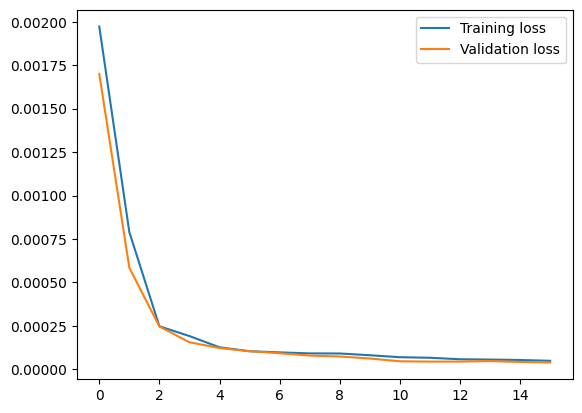

In [101]:
# get best result
train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch = results[best_result]

# plot training and validation losses
fig, ax = plt.subplots()
plt.plot(train_losses_tdnn, label='Training loss')
plt.plot(val_losses_tdnn, label='Validation loss')
plt.legend()

In [ ]:
# retrains the model with the best hyperparameters
window_size, hidden_size, lr = best_result
tdnn = TDNN(window_size, hidden_size, 1)
optimizer = torch.optim.Adam(tdnn.parameters(), lr=lr)
loss_fn = nn.MSELoss()
mae_fn = nn.L1Loss()
train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch = train_tdnn(tdnn, optimizer, loss_fn, mae_fn, x_dev, y_dev, None, None, epochs=epoch + 1)

In [103]:
# predict the training set
y_hats = torch.Tensor()
for i in range(tdnn.window_size - 1, x_dev.shape[1]):
    x_i = x_dev[:, i - tdnn.window_size + 1: i + 1]
    with torch.no_grad():
        y_hat = tdnn(x_i)
        y_hats = torch.cat((y_hats, y_hat))



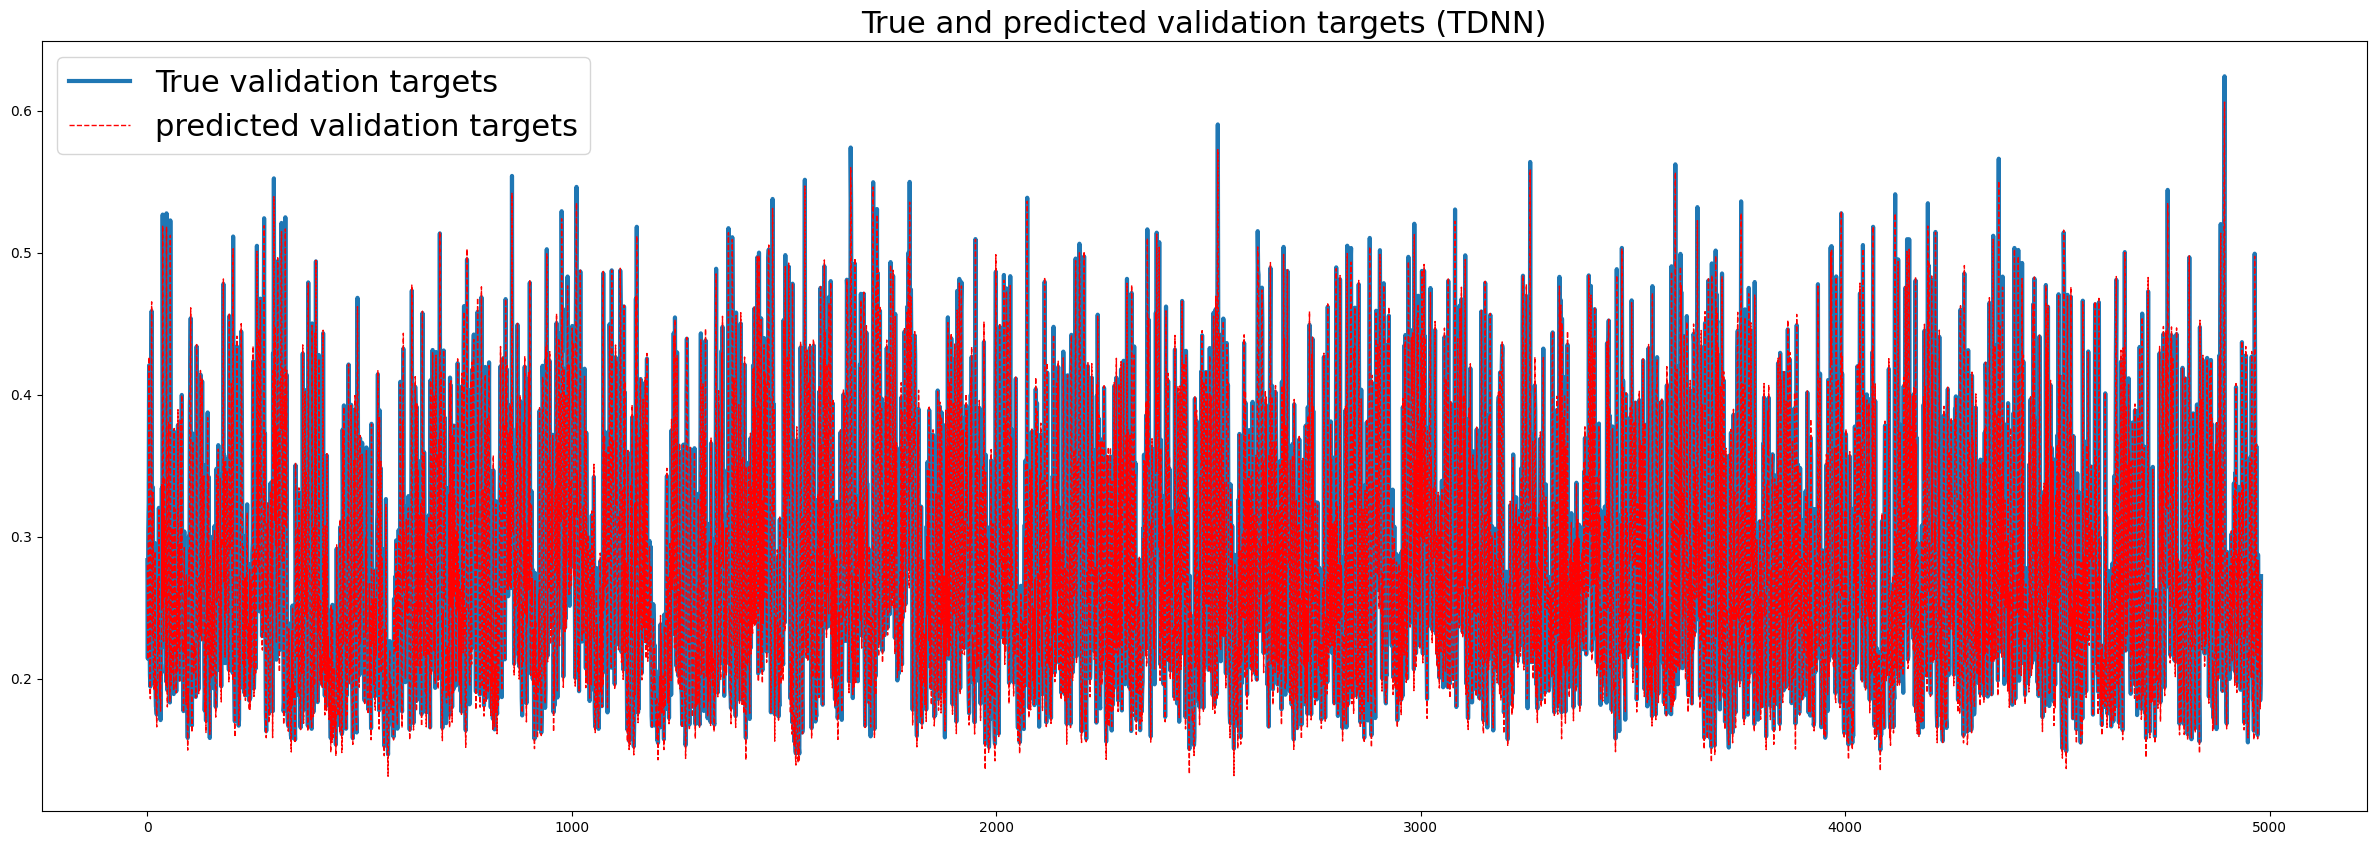

In [104]:
plt.figure(figsize=(30,10))
y_hats = y_hats.reshape(-1)
plt.plot(y_dev.reshape(-1)[19:], label ='True validation targets', linewidth=3)
plt.plot(y_hats, label ='predicted validation targets', linestyle = '--', color='r', linewidth=1)
plt.legend(fontsize=22)
plt.title('True and predicted training targets (TDNN)', fontsize=22)
plt.show()

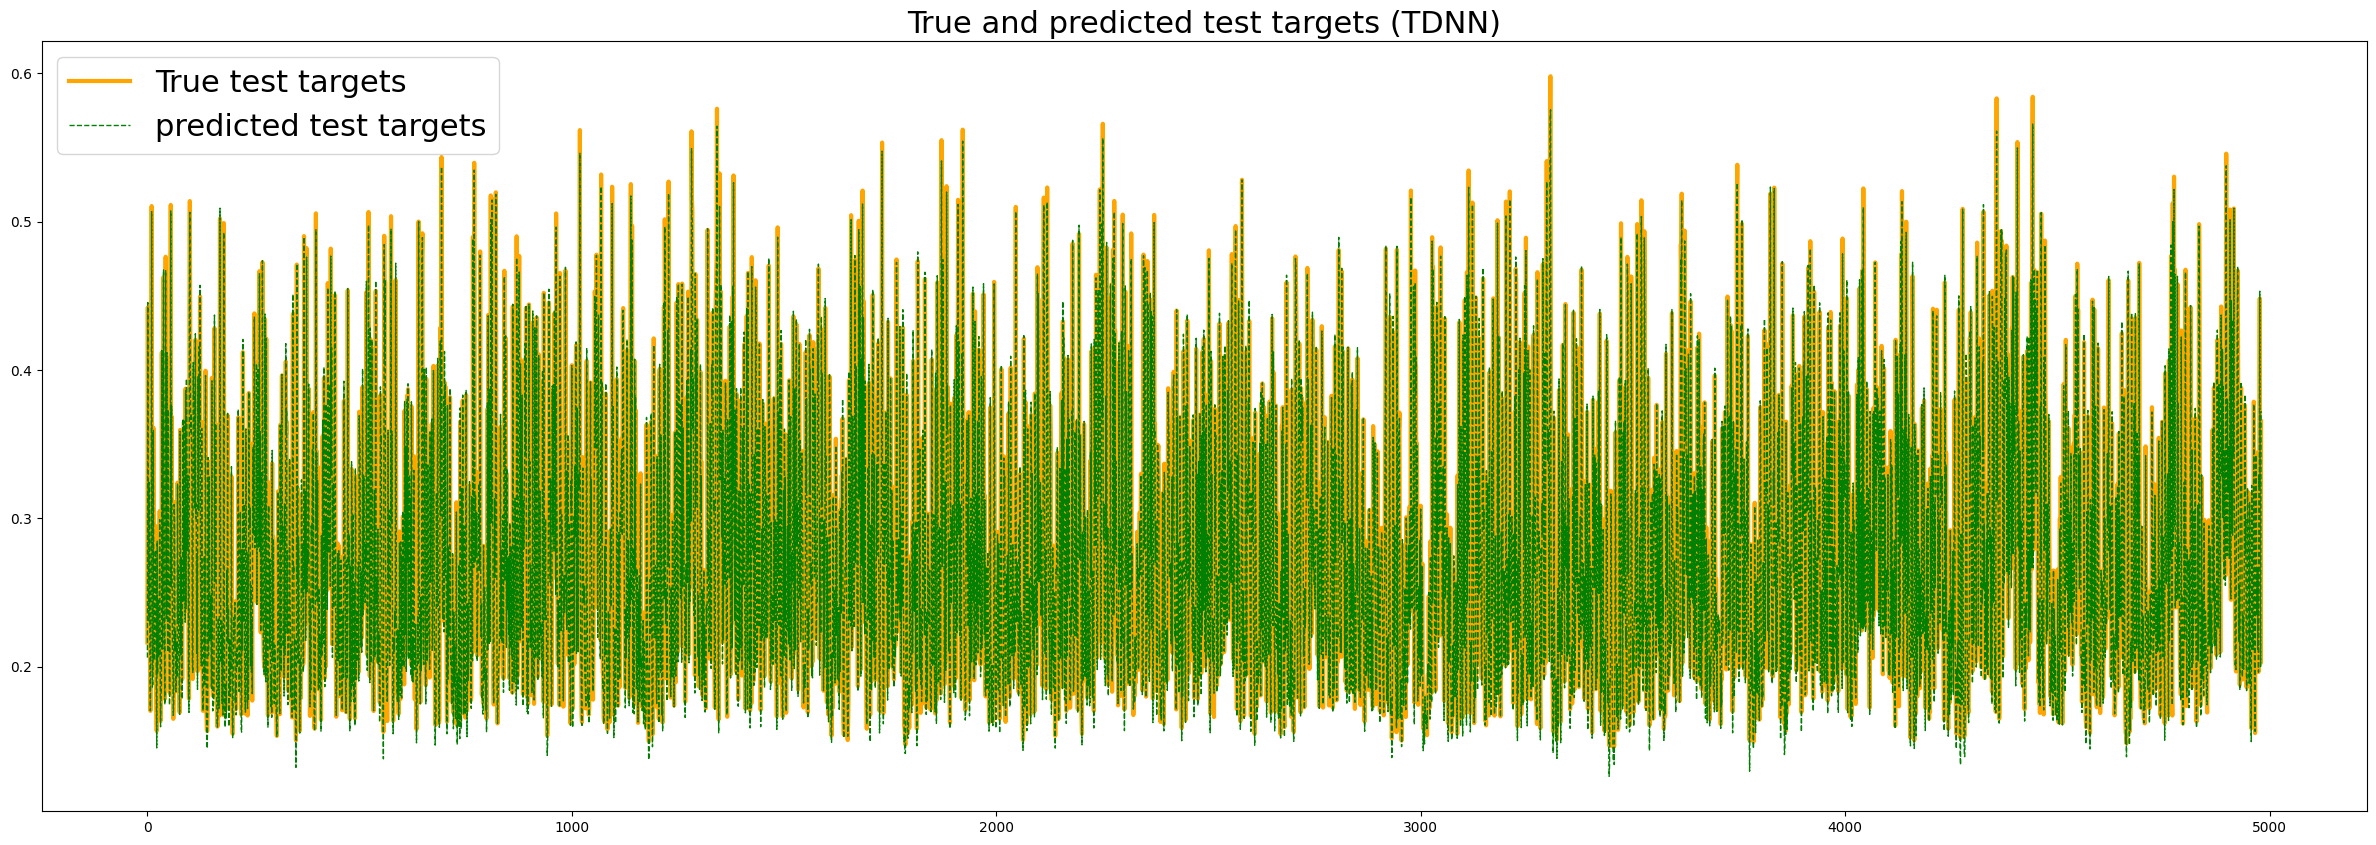

In [108]:
# predict the test set
y_hats_test_tdnn = torch.Tensor()
for i in range(tdnn.window_size - 1, x_test.shape[1]):
    x_i = x_test[:, i - tdnn.window_size + 1: i + 1]
    with torch.no_grad():
        y_hat = tdnn(x_i)
        y_hats_test_tdnn = torch.cat((y_hats_test_tdnn, y_hat))

plt.figure(figsize=(30,10))
y_hats_test_tdnn = y_hats_test_tdnn.reshape(-1)
plt.plot(y_test.reshape(-1)[19:], label ='True test targets', linewidth=3, color='orange')
plt.plot(y_hats_test_tdnn, label ='predicted test targets', linestyle = '--', color='g', linewidth=1)
plt.title('True and predicted test targets (TDNN)', fontsize=22)
plt.legend(fontsize=22)

plt.show()


In [118]:
from pprint import pprint
final_results = dict()
final_results['TDNN'] = dict()
final_results['TDNN']['hyperparameters'] = { 'window_size': window_size, 'hidden_size': hidden_size, 'lr': lr }
final_results['TDNN']['train_loss'] = loss_fn(y_hats, y_dev.reshape(-1)[19:]).item()
final_results['TDNN']['train_mae'] = mae_fn(y_hats, y_dev.reshape(-1)[19:]).item()
final_results['TDNN']['test_loss'] = loss_fn(y_hats_test_tdnn, y_test.reshape(-1)[19:]).item()
final_results['TDNN']['test_mae'] = mae_fn(y_hats_test_tdnn, y_test.reshape(-1)[19:]).item()
pprint(final_results)

import json
with open('final_results.json', 'w') as f:
    json.dump(final_results, f)
    

{'TDNN': {'hyperparameters': {'hidden_size': 100,
                              'lr': 0.01,
                              'window_size': 20},
          'test_loss': 4.6173623559297994e-05,
          'test_mae': 0.00545179657638073,
          'train_loss': 4.2538304114714265e-05,
          'train_mae': 0.005273977294564247}}


## Recurrent Neural Network

In [82]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nonlinearity='relu') -> None:
        super().__init__()
        self.rnn =nn.RNN(input_size, hidden_size, nonlinearity = nonlinearity, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
    def forward(self, x, h_0 =None):
        outputs, h_T = self.rnn(x, h_0)
        y = self.linear(outputs)
        return y, h_T
    

In [119]:
x_train = x_train.T
x_val = x_val.T
x_test = x_test.T

y_train = y_train.T
y_val = y_val.T
y_test = y_test.T

In [139]:
# training loop
def train_rnn(rnn, optimizer, loss_fn, mae_fn, x_train, y_train, x_val, y_val, epochs=100, n_steps_update=32, patience=5, eps=1e-5):
    epochs =100
    train_losses_rnn = []
    train_maes_rnn = []
    val_losses_rnn = []
    val_maes_rnn = []
    loop = tqdm(range(epochs), desc='Training')
    for epoch in loop:
        loop.set_description('Training, epoch: {}'.format(epoch))
        # training phase
        rnn.train()
        y_hat, h_last = rnn(x_train)
        l = loss_fn(y_hat, y_train)
        m = mae_fn(y_hat, y_train)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses_rnn.append(l.item())
        train_maes_rnn.append(m.item())

        # validation phase
        rnn.eval()
        with torch.no_grad():
            y_hat, _ = rnn(x_val, h_last)
            v_l = loss_fn(y_hat, y_val)
            v_m = mae_fn(y_hat, y_val)
            val_losses_rnn.append(v_l.item())
            val_maes_rnn.append(v_m.item())
            loop.set_postfix({'loss': l.item(), 'mae': m.item(), 'val_loss': v_l.item(), 'val_mae': v_m.item()})
    
    return train_losses_rnn, train_maes_rnn, val_losses_rnn, val_maes_rnn


In [141]:


rnn = VanillaRNN(1, 100, 1)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

loss_fn = nn.MSELoss()
mae_fn = nn.L1Loss()

train_losses_rnn, train_maes_rnn, val_losses_rnn, val_maes_rnn = train_rnn(rnn, optimizer, 
                                                                           loss_fn, mae_fn, x_train, y_train, x_val, y_val, epochs=300)

Training, epoch: 3:   3%|▎         | 3/100 [00:03<01:50,  1.14s/it, loss=0.0119, mae=0.0801, val_loss=0.00939, val_mae=0.071]


KeyboardInterrupt: 

In [107]:
val_losses = [v.detach() for v in val_losses]
val_maes = [v.detach() for v in val_maes]


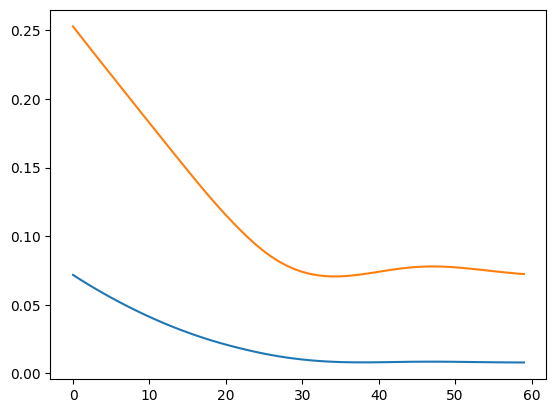

In [109]:
plt.plot(  np.arange(60), val_losses, val_maes)

In [126]:
class TransducerRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_layers=1) -> None:
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers= rnn_layers)
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
    def forward(self, x, h_0 =None):
        x = x.reshape(-1, 1)
        if h_0 is not None:
            h_0 = h_0.reshape(-1, 1)
        outputs, h_T = self.rnn(x, h_0)
        
        y = self.linear(outputs)
        y = self.relu(y)
        y = self.linear2(y)
        return y, h_T
    
 

In [127]:
model = TransducerRNN(1, 10, 1, rnn_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr =1e-3, weight_decay= 1e-6)
loss = torch.nn.MSELoss()
mae =torch.nn.L1Loss()

In [128]:
train_losses_rnn =[]
val_losses_rnn=[]
val_maes_rnn=[]


In [130]:

# training loop
epochs =5000
h_last= None # first hidden state
for epoch in range(epochs):
    optimizer.zero_grad()
    running_loss =0
    # training 
    print(f'Epoch {epoch}')
    optimizer.zero_grad()
    y_hat,  h_last= model(x_train)
    l = loss( y_hat, y_train)
    running_loss += l
    l.backward()
    optimizer.step()
    running_loss = running_loss/x_train.shape[0]
    print(f'Training loss: {running_loss}')
    train_losses_rnn.append(running_loss.detach())


    # validation
    with torch.no_grad():
        y_hat, _ = model(x_val)
        val_loss = loss( y_hat, y_val.T)
        val_mae = mae(y_hat, y_val.T)
        val_losses_rnn.append(val_loss.detach())
        val_maes_rnn.append(val_mae.detach())
        print(f'Validation loss: {val_loss}')
        print(f'MAE: {val_mae}')
        print('Relative MAE: ', val_mae / y_val.abs().mean())    

Epoch 0
Training loss: 1.860668589870329e-06
Validation loss: 0.007815012708306313
MAE: 0.07048256695270538
Relative MAE:  tensor(0.2542)
Epoch 1
Training loss: 1.8610494407766964e-06
Validation loss: 0.007814921438694
MAE: 0.0704832524061203
Relative MAE:  tensor(0.2542)
Epoch 2
Training loss: 1.8610257939144503e-06
Validation loss: 0.007813823409378529
MAE: 0.07049863040447235
Relative MAE:  tensor(0.2542)
Epoch 3
Training loss: 1.8606356206873897e-06
Validation loss: 0.00781188253313303
MAE: 0.07052743434906006
Relative MAE:  tensor(0.2543)
Epoch 4
Training loss: 1.8599322402224061e-06
Validation loss: 0.007809304632246494
MAE: 0.0705685019493103
Relative MAE:  tensor(0.2545)
Epoch 5
Training loss: 1.8589788624012726e-06
Validation loss: 0.007806310895830393
MAE: 0.07062078267335892
Relative MAE:  tensor(0.2547)
Epoch 6
Training loss: 1.8578431308924337e-06
Validation loss: 0.007803124841302633
MAE: 0.07068320363759995
Relative MAE:  tensor(0.2549)
Epoch 7
Training loss: 1.856593371

KeyboardInterrupt: 

Text(0.5, 0, 'iteration')

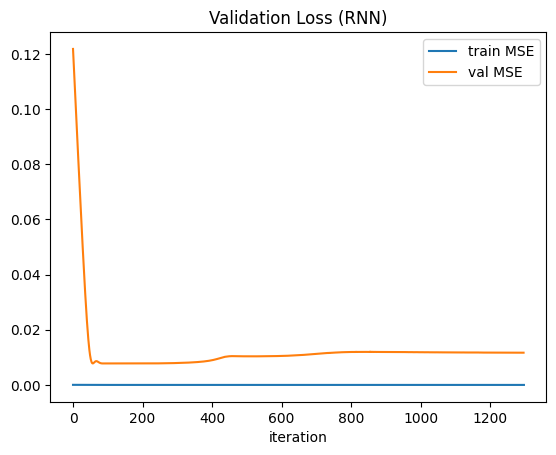

In [131]:
plt.plot((np.array(train_losses_rnn[10:])), label='train MSE')
plt.plot((np.array(val_losses_rnn[10:])), label='val MSE')
plt.legend()
plt.title('Validation Loss (RNN)')
plt.xlabel('iteration')


In [132]:
with torch.no_grad():
    y_hats, _ = model(torch.cat((x_train, x_val), dim=1))
    print(y_hats.shape)

y_hats_train = y_hats[ :4000,:] 
y_hats_val = y_hats[4000:5000,:]
print(y_hats_val.shape)
plt.figure(figsize=(30,10))
plt.plot(y_train.squeeze(), label ='True training targets', linewidth=3)
plt.plot(y_hats_train, label ='predicted training targets', linestyle = '--', color='r', linewidth=3)
plt.plot(np.arange(4000, 5000), y_val.squeeze(), label ='True validation targets', linewidth=3)
plt.plot(np.arange(4000, 5000), y_hats_val.squeeze(), label ='predicted validation targets', linestyle = '--', color='g', linewidth=3)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 4000 but got size 1000 for tensor number 1 in the list.

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_layers=1, activation_function ='relu') -> None:
        super().__init__()
        # define the rnn 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.o2h = nn.Linear(output_size, hidden_size) # for the decoder
        if activation_function == 'relu':
            self.activation = nn.ReLU()
        elif activation_function == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError('Activation function not supported')
        

    def forward(self, x, y, h_0 =None, p_teacher_forcing=0.5):
        outputs = []
        if h_0 is None:
            h_t = torch.zeros(1, self.hidden_size)
        else:
            h_t = h_0
        o_t = torch.zeros(self.output_size, 1) # initial output set to 0
        for i in range(x.shape[1]):
            x_t = x[:, i].reshape(1, -1)
            if torch.rand(1) < p_teacher_forcing and i !=0 : # choose whether to use the true target or the previous output
                y_t_minus_one = y[:, i-1].reshape(1, -1)
            else:
                y_t_minus_one = o_t
            
            h_t = self.activation (self.i2h(x_t) +  # input to hidden
                                    self.h2h(h_t) + # recurrence
                                    self.o2h(y_t_minus_one)) # decoder input

            o_t = self.h2o(h_t)
            outputs.append(o_t)
        return torch.cat(outputs, dim=1), h_t

In [50]:
x_train = x_train.T
x_val = x_val.T
x_test = x_test.T

y_train = y_train.T
y_val = y_val.T
y_test = y_test.T

In [52]:
rnn = DecoderRNN( input_size=1, hidden_size=20, output_size=1, activation_function='relu')

rnn(x= x_train, y=y_train)

(tensor([[-0.3747, -0.2756, -0.3019,  ..., -0.2959, -0.2957, -0.1960]],
        grad_fn=<CatBackward0>),
 tensor([[0.0000, 0.0000, 0.0000, 2.4881, 0.7831, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.3257, 1.9275, 0.0000, 0.0000, 0.0000, 1.1235, 0.9344, 0.5217,
          0.7177, 1.1388]], grad_fn=<ReluBackward0>))

In [65]:
rnn = DecoderRNN( input_size=1, hidden_size=10, output_size=1, activation_function='tanh')
optimizer = torch.optim.SGD(rnn.parameters(), lr =1e-4, nesterov=True, momentum=0.9)
loss = torch.nn.MSELoss()
mae = torch.nn.L1Loss()

val_losses_rnn=[]
val_maes_rnn=[]
epochs =1000
h_last= None # first hidden state

for epoch in range(epochs):
    optimizer.zero_grad()
    running_loss =0
    # training 
    print(f'Epoch {epoch}')
    optimizer.zero_grad()
    y_hat,  h_last= rnn(x_train, y_train)
    l = loss( y_hat, y_train)
    running_loss += l
    l.backward()
    optimizer.step()
    running_loss = running_loss/x_train.shape[0]
    print(f'Training loss: {running_loss}')


    # validation
    y_hat, _ = rnn(x_val, y_val)
    val_loss = loss( y_hat, y_val)
    val_mae = mae(y_hat, y_val)
    val_losses_rnn.append(val_loss.detach())
    val_maes_rnn.append(val_mae.detach())
    print(f'Validation loss: {val_loss}')
    print(f'MAE: {val_mae}')
    print('Relative MAE: ', val_mae / y_val.abs().mean())

Epoch 0
Training loss: 0.4349198043346405
Validation loss: 0.4300173223018646
MAE: 0.6475985050201416
Relative MAE:  tensor(2.3352, grad_fn=<DivBackward0>)
Epoch 1
Training loss: 0.43516990542411804
Validation loss: 0.43341687321662903
MAE: 0.6505609750747681
Relative MAE:  tensor(2.3459, grad_fn=<DivBackward0>)
Epoch 2
Training loss: 0.43272921442985535
Validation loss: 0.43088772892951965
MAE: 0.6485478281974792
Relative MAE:  tensor(2.3386, grad_fn=<DivBackward0>)
Epoch 3
Training loss: 0.42504817247390747
Validation loss: 0.4225541353225708
MAE: 0.6422363519668579
Relative MAE:  tensor(2.3159, grad_fn=<DivBackward0>)
Epoch 4
Training loss: 0.4217687249183655
Validation loss: 0.419877290725708
MAE: 0.6398958563804626
Relative MAE:  tensor(2.3075, grad_fn=<DivBackward0>)
Epoch 5
Training loss: 0.41568079590797424
Validation loss: 0.4113774001598358
MAE: 0.6334149837493896
Relative MAE:  tensor(2.2841, grad_fn=<DivBackward0>)
Epoch 6
Training loss: 0.4114040434360504
Validation loss: 

KeyboardInterrupt: 

In [58]:
y_hat, _ = rnn(x_val, y_val)

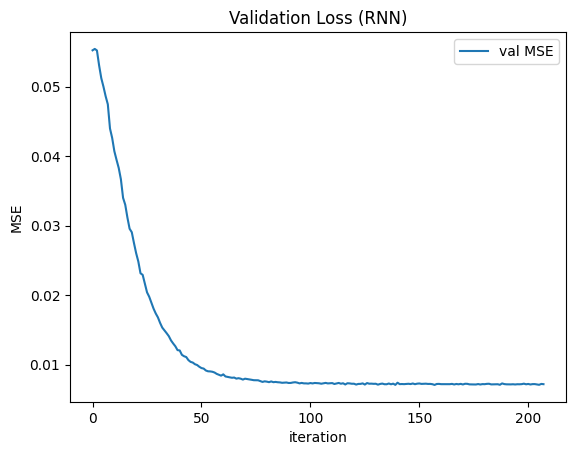

In [59]:
plt.plot(val_losses_rnn, label='val MSE')   
plt.legend()
plt.title('Validation Loss (RNN)')
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.show()


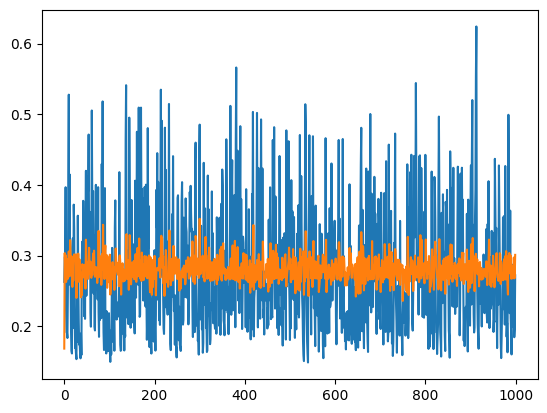

In [60]:
plt.plot(y_val.T)
plt.plot(y_hat.detach().T)